In [18]:
import shutil
import time
import os
import librosa
from librosa import display
import matplotlib.pyplot as plt

count=0

path1='/content/drive/MyDrive/Datasetvideo'

for subdir, dirs, files in os.walk(path1):
  if(subdir)=='/content/drive/MyDrive/Datasetvideo/landmarks':continue
  print(subdir)
  for file in files:
      
      try:
        emo = int(file[7:8]) - 1 
        if(emo==6 or emo==7):
          continue
        if(emo==0):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/neutral/'+file))
          
        if(emo==1):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/calm/'+file))

        if(emo==2):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/happy/'+file))
        
        if(emo==3):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/sad/'+file))
        
        if(emo==4):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/angry/'+file))
        
        if(emo==5):
          newf=subdir+'/'+file
          shutil.copyfile(newf,('/content/drive/MyDrive/Datasetvideowithlabel/fearful/'+file))
        
    
        
        
      # If the file is not valid, skip it
      except ValueError:
        continue


/content/drive/MyDrive/Datasetvideo
/content/drive/MyDrive/Datasetvideo/Actor_01
/content/drive/MyDrive/Datasetvideo/Actor_02
/content/drive/MyDrive/Datasetvideo/Actor_03
/content/drive/MyDrive/Datasetvideo/Actor_04
/content/drive/MyDrive/Datasetvideo/Actor_05


In [20]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [21]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1064960/45929032 bytes (2.3%)2719744/45929032 bytes (5.9%)4300800/45929032 bytes (9.4%)5947392/45929032 bytes (12.9%)7577600/45929032 bytes (16.5%)8880128/45929032 bytes (19.3%)10944512/45929032 bytes (23.8%)12902400/45929032 bytes (28.1%)14876672/45929032 bytes (32.4%)17276928/45929032 bytes (37.6%)18751488/45929032 bytes (40.8%)20611072/45929032 bytes (44.9%)22495232/

In [22]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

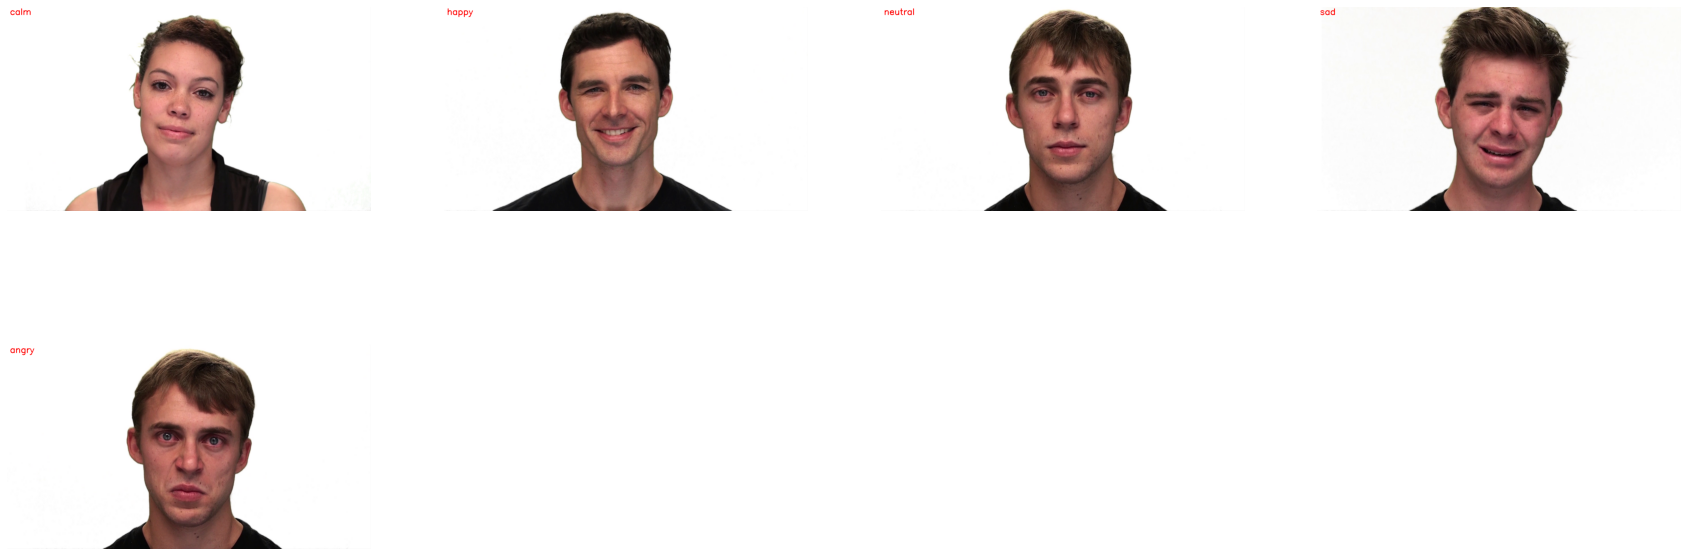

In [33]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('/content/drive/MyDrive/Datasetvideowithlabel')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)),5)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Datasetvideowithlabel/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Datasetvideowithlabel/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
  
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [38]:
image_height, image_width = 64, 64
max_images_per_class = 2000

dataset_directory = "/content/drive/MyDrive/Datasetvideowithlabel"
classes_list = ["neutral", "calm", "happy", "sad","angry","fearful"]

model_output_size = len(classes_list)

In [39]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [40]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [41]:
features, labels = create_dataset()

Extracting Data of Class: neutral
Extracting Data of Class: calm
Extracting Data of Class: happy
Extracting Data of Class: sad
Extracting Data of Class: angry
Extracting Data of Class: fearful


In [42]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [43]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [44]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

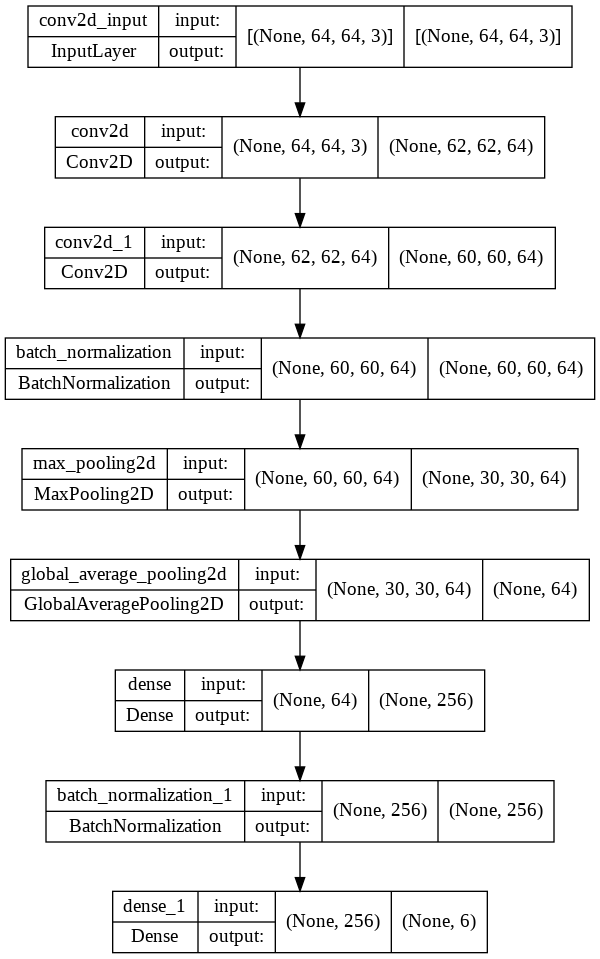

In [45]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [46]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
1920/1920 [==============================] - 39s 15ms/step - loss: 1.7533 - accuracy: 0.2552 - val_loss: 7.4474 - val_accuracy: 0.2135
Epoch 2/50
1920/1920 [==============================] - 28s 15ms/step - loss: 1.4713 - accuracy: 0.4089 - val_loss: 21.9318 - val_accuracy: 0.1682
Epoch 3/50
1920/1920 [==============================] - 29s 15ms/step - loss: 1.1819 - accuracy: 0.5490 - val_loss: 17.9976 - val_accuracy: 0.1646
Epoch 4/50
1920/1920 [==============================] - 29s 15ms/step - loss: 0.9471 - accuracy: 0.6456 - val_loss: 6.7810 - val_accuracy: 0.3818
Epoch 5/50
1920/1920 [==============================] - 28s 14ms/step - loss: 0.8090 - accuracy: 0.7065 - val_loss: 17.4877 - val_accuracy: 0.1703
Epoch 6/50
1920/1920 [==============================] - 28s 15ms/step - loss: 0.7403 - accuracy: 0.7318 - val_loss: 15.2235 - val_accuracy: 0.1802
Epoch 7/50
1920/1920 [==============================] - 28s 15ms/step - loss: 0.6756 - accuracy: 0.7602 - val_loss: 4.66

In [47]:
model_evaluation_history = model.evaluate(features_test, labels_test)

75/75 [==============================] - 1s 10ms/step - loss: 0.4726 - accuracy: 0.8542


In [48]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

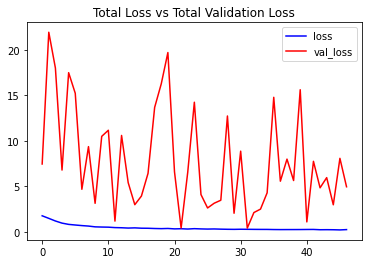

In [49]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

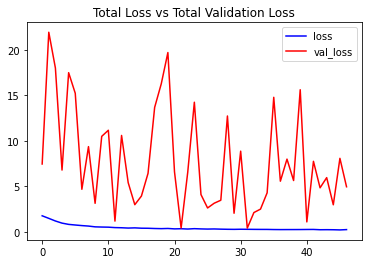

In [50]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')